In [1]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import uproot
from getS50 import *
from draw_compare_multiply import draw_compare_multiply
from sklearn.preprocessing import PowerTransformer
from autogluon.tabular import TabularDataset, TabularPredictor
from sklearn.model_selection import train_test_split

In [2]:
precision = dict()


In [3]:
def twoPointAngle(theta1, theta2, phi1, phi2):
    return np.rad2deg(
        np.arccos(
            np.sin(np.deg2rad(theta1))
            * np.sin(np.deg2rad(theta2))
            * np.cos(np.deg2rad(phi1 - phi2))
            + np.cos(np.deg2rad(theta1)) * np.cos(np.deg2rad(theta2))
        )
    )


Energy_bin = np.logspace(0.6, 4.6, 21)
Energy_bin_center = 10**((np.log10(Energy_bin[:-1]) +
                         np.log10(Energy_bin[1:]))/2)
Energy_min = Energy_bin[:-1]
Energy_max = Energy_bin[1:]
bins_1 = np.linspace(-2, 2, 41)

def mkdir(path):
    if not os.path.exists(path):
        os.makedirs(path)


def check_fit(energy_pred, energy_orgin, title, savepath):
    plt.tight_layout()
    _, axes = plt.subplots(4, 5, sharey=True, figsize=(15, 15))
    precision_ = list()
    axes = axes.reshape(-1)
    for i in range(len(Energy_bin)-1):
        need = np.where((Energy_min[i] < energy_pred)
                        & (Energy_max[i] > energy_pred))
        need_draw = np.log(energy_pred[need]/energy_orgin[need])
        precision_.append(np.sqrt(np.mean(need_draw**2)))
        if need_draw.size != 0:
            axes[i].hist(need_draw, bins=bins_1, density=True)
            axes[i].set_title(
                f"{Energy_min[i]:.2f}<E_pred<{Energy_max[i]:.2f}", fontsize=10)
            axes[i].set_ylim(0, 4)
            axes[i].text(-2, 3,
                         f"error={np.sqrt(np.mean(need_draw**2)):.2f}\nstd={np.std(need_draw):.2f}\nmean={np.mean(need_draw):.2f}\n")
    plt.xlabel("ln(pred/true)")
    mkdir(savepath)
    plt.savefig(os.path.join(savepath, "resolution.png"))
    plt.show()
    plt.close()
    hist_orgin, _ = np.histogram(
        np.log10(energy_orgin), bins=np.log10(Energy_bin))
    hist_recon, _ = np.histogram(
        np.log10(energy_pred), bins=np.log10(Energy_bin))

    plt.errorbar(
        np.log10(Energy_bin_center),
        hist_orgin,
        np.sqrt(hist_orgin),
        np.ones(len(Energy_bin_center)) * 0.1,
        fmt=".",
        label="true Energy"
    )
    plt.errorbar(
        np.log10(Energy_bin_center),
        hist_recon,
        np.sqrt(hist_recon),
        np.ones(len(Energy_bin_center)) * 0.1,
        fmt=".",
        label="pred Energy"
    )
    plt.title(title)
    plt.axvline(x=1.2, color='r', linestyle='--')
    plt.axvline(x=2.2, color='r', linestyle='--')
    plt.xlabel("log10energy")
    plt.ylabel("dN")
    plt.legend()
    plt.yscale("log")
    plt.savefig(os.path.join(savepath, "compare_bin.png"))
    plt.show()
    plt.close()


    plt.scatter(np.log10(energy_pred), np.log10(energy_orgin), s=1)
    plt.plot([0, 5], [0, 5], c="r")
    plt.xlabel("energy_pred")
    plt.ylabel("energy_orgin")
    plt.savefig(os.path.join(savepath, "compare.png"))
    plt.show()
    precision[title] = precision_
    plt.close()
    for i in range(len(Energy_bin)-1):
        print(Energy_bin[i],Energy_bin[i+1],(hist_recon[i]-hist_orgin[i])/hist_orgin[i])

def draw_precision():
    for key in precision.keys():
        plt.plot(Energy_bin_center,
                 precision[key], "o:", label=key)
    plt.legend()
    plt.xlabel("Energy(TeV)")
    plt.ylabel("energy resolution")
    plt.xscale("log")
    plt.yscale("log")
    # plt.ylim(0.1, 0.6)
    # plt.xlim(10, 1e4)
    plt.savefig("./precision.png")
    plt.show()

In [4]:
test_size = 0.4
savepath = "./fig/energy_reconstruction/"

In [5]:
file = uproot.open("/home2/chenxu/data/gamma_all.root")


In [6]:
file["asresult"].keys()

['runno',
 'evno',
 'mode',
 'mjd',
 'nch',
 'inout',
 'oldtrig',
 'theta',
 'phi',
 'evenodd',
 'sigma',
 'cx',
 'cy',
 'sumpf',
 'sumpd',
 'mr1',
 'mr2',
 'summd',
 'summdold',
 'summd8',
 'nchmd',
 'ne',
 'age',
 'ndf',
 'chi2',
 'fptcl_r',
 'dptcl_r',
 'fn_r',
 'dn_r',
 'JPne',
 'JPne_err',
 'JPage_err',
 'JPage',
 'JPchi2',
 'JPdof',
 'nch_cx',
 'sigma_cx',
 'ne_cx',
 'age_cx',
 'cx_cx',
 'cy_cx',
 'theta_cx',
 'phi_cx',
 'prie_num',
 'prik',
 'priid',
 'pritheta',
 'priphi',
 'prie',
 'prine',
 'pricx',
 'pricy']

In [7]:
data = file["asresult"].arrays(["nch", "theta", "phi", "sigma", "cx", "cy", "sumpf",
                               "summd", "mr1", "ne", "age", "pritheta", "priphi", "prie", "inout"], library="np")


In [ ]:
data["cr"] = np.sqrt(data["cx"]**2+data["cy"]**2)
data["log10Energy"] = np.log10(data["prie"]/1000)
data["pritheta"] = np.rad2deg(data["pritheta"])
data["priphi"] = 180-np.rad2deg(data["priphi"])
data["priphi"][data["priphi"] > 180] = data["priphi"][data["priphi"] > 180]-360
data["S50"] = getS50(data["ne"], data["age"])
data["deltatheta"] = data["theta"]-data["pritheta"]
data["deltaphi"] = data["phi"]-data["priphi"]
data["deltaphi"][data["deltaphi"] <-180]+=360
data["deltaphi"][data["deltaphi"] >180]-=360

In [ ]:
cuted = np.where((data["theta"] < 50) & (data["nch"] >= 16)
                 & (data["inout"] == 1) & (data['sigma'] < 1.)
                 & (data["age"] > 0.31) & (data['age'] < 1.3)
                 & (data["S50"] > 10**-1.2)
                 & (data['sumpf'] > 200)
                 & ((data["summd"] < 1.8e-5*data["sumpf"]**1.8) | (data["summd"] < 0.4)))
# cuted = np.where(np.ones_like(data["theta"])==1)


In [ ]:
train_index, test_index = train_test_split(
    range(cuted[0].shape[0]), test_size=0.4, random_state=42, shuffle=True)


In [ ]:
data_train = {key:data[key][cuted][train_index] for key in data.keys()}
data_test = {key:data[key][cuted][test_index] for key in data.keys()}

In [ ]:
pd_data = pd.DataFrame(data_train)
pd_data_test = pd.DataFrame(data_test)

In [ ]:
# pd_data[["ne","sumpf"]]=np.log10(pd_data[["ne","sumpf"]])
# pd_data_test[["ne","sumpf"]]=np.log10(pd_data_test[["ne","sumpf"]])
pd_data[["sumpf"]]=np.log10(pd_data[["sumpf"]])
pd_data_test[["sumpf"]]=np.log10(pd_data_test[["sumpf"]])

In [ ]:
model_dict = dict()

In [27]:
train_data_autogluon = TabularDataset(pd_data)
test_data_autogluon = TabularDataset(pd_data_test)

In [18]:

for label in [
        "log10Energy",
        "deltatheta",
        "deltaphi"
]:
    columns_need = [label, "nch", "theta", "phi", "sigma",
                    "cx", "cy", "sumpf", "summd", "mr1"]

    columns_drop = list()
    for column in train_data_autogluon.columns:
        if column not in columns_need:
            columns_drop.append(column)
    predictor = TabularPredictor(label=label, path=f"/home2/hky/github/Gamma_Energy/AllSky/AutogluonModels/agModels_angle_withoutcut/{label}").fit(
        train_data_autogluon.drop(columns=columns_drop), num_gpus=2)
    model_dict[label] = predictor


	Consider setting `time_limit` to ensure training finishes within an expected duration or experiment with a small portion of `train_data` to identify an ideal `presets` and `hyperparameters` configuration.
Beginning AutoGluon training ...
AutoGluon will save models to "/home2/hky/github/Gamma_Energy/AllSky/AutogluonModels/agModels_angle_withoutcut/log10Energy/"
AutoGluon Version:  0.7.0
Python Version:     3.9.16
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Debian 5.10.162-1 (2023-01-21)
Train Data Rows:    6397900
Train Data Columns: 9
Label Column: log10Energy
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (4.998421793472894, -0.522761731618134, 1.38855, 0.74206)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify

[1000]	valid_set's rmse: 0.294899
[2000]	valid_set's rmse: 0.292058
[3000]	valid_set's rmse: 0.290713
[4000]	valid_set's rmse: 0.28998
[5000]	valid_set's rmse: 0.2895
[6000]	valid_set's rmse: 0.289159
[7000]	valid_set's rmse: 0.288853
[8000]	valid_set's rmse: 0.288638
[9000]	valid_set's rmse: 0.288477
[10000]	valid_set's rmse: 0.28832


	-0.2883	 = Validation score   (-root_mean_squared_error)
	443.48s	 = Training   runtime
	1.68s	 = Validation runtime
Fitting model: LightGBM ...
	Training LightGBM with GPU, note that this may negatively impact model quality compared to CPU training.


[1000]	valid_set's rmse: 0.29098
[2000]	valid_set's rmse: 0.288787
[3000]	valid_set's rmse: 0.288079
[4000]	valid_set's rmse: 0.287657
[5000]	valid_set's rmse: 0.287456
[6000]	valid_set's rmse: 0.287315
[7000]	valid_set's rmse: 0.287207
[8000]	valid_set's rmse: 0.287118
[9000]	valid_set's rmse: 0.287116
[10000]	valid_set's rmse: 0.287075


	-0.2871	 = Validation score   (-root_mean_squared_error)
	354.3s	 = Training   runtime
	1.31s	 = Validation runtime
Fitting model: RandomForestMSE ...
	-0.2959	 = Validation score   (-root_mean_squared_error)
	755.81s	 = Training   runtime
	0.13s	 = Validation runtime
Fitting model: CatBoost ...
	Training CatBoost with GPU, note that this may negatively impact model quality compared to CPU training.
	-0.288	 = Validation score   (-root_mean_squared_error)
	74.65s	 = Training   runtime
	0.03s	 = Validation runtime
Fitting model: ExtraTreesMSE ...
	-0.2981	 = Validation score   (-root_mean_squared_error)
	358.38s	 = Training   runtime
	0.13s	 = Validation runtime
Fitting model: NeuralNetFastAI ...
No improvement since epoch 4: early stopping
	-0.2937	 = Validation score   (-root_mean_squared_error)
	1616.56s	 = Training   runtime
	0.28s	 = Validation runtime
Fitting model: XGBoost ...
	-0.2876	 = Validation score   (-root_mean_squared_error)
	79.67s	 = Training   runtime
	1.16s	 = Valid

[1000]	valid_set's rmse: 0.288642
[2000]	valid_set's rmse: 0.287527
[3000]	valid_set's rmse: 0.287236
[4000]	valid_set's rmse: 0.286995
[5000]	valid_set's rmse: 0.286828
[6000]	valid_set's rmse: 0.286714
[7000]	valid_set's rmse: 0.286678
[8000]	valid_set's rmse: 0.28662
[9000]	valid_set's rmse: 0.286599
[10000]	valid_set's rmse: 0.286612


	-0.2866	 = Validation score   (-root_mean_squared_error)
	462.65s	 = Training   runtime
	0.98s	 = Validation runtime
Fitting model: WeightedEnsemble_L2 ...
	-0.2862	 = Validation score   (-root_mean_squared_error)
	0.75s	 = Training   runtime
	0.0s	 = Validation runtime
AutoGluon training complete, total runtime = 4935.79s ... Best model: "WeightedEnsemble_L2"
TabularPredictor saved. To load, use: predictor = TabularPredictor.load("/home2/hky/github/Gamma_Energy/AllSky/AutogluonModels/agModels_angle_withoutcut/log10Energy/")
	Consider setting `time_limit` to ensure training finishes within an expected duration or experiment with a small portion of `train_data` to identify an ideal `presets` and `hyperparameters` configuration.
Beginning AutoGluon training ...
AutoGluon will save models to "/home2/hky/github/Gamma_Energy/AllSky/AutogluonModels/agModels_angle_withoutcut/deltatheta/"
AutoGluon Version:  0.7.0
Python Version:     3.9.16
Operating System:   Linux
Platform Machine:   x86_64

[1000]	valid_set's rmse: 2.22863
[2000]	valid_set's rmse: 2.21008
[3000]	valid_set's rmse: 2.20076
[4000]	valid_set's rmse: 2.1966
[5000]	valid_set's rmse: 2.19421
[6000]	valid_set's rmse: 2.19237
[7000]	valid_set's rmse: 2.19015
[8000]	valid_set's rmse: 2.1892
[9000]	valid_set's rmse: 2.18864
[10000]	valid_set's rmse: 2.18765


	-2.1876	 = Validation score   (-root_mean_squared_error)
	379.36s	 = Training   runtime
	1.45s	 = Validation runtime
Fitting model: LightGBM ...
	Training LightGBM with GPU, note that this may negatively impact model quality compared to CPU training.


[1000]	valid_set's rmse: 2.18483
[2000]	valid_set's rmse: 2.17925


	-2.1789	 = Validation score   (-root_mean_squared_error)
	111.83s	 = Training   runtime
	0.23s	 = Validation runtime
Fitting model: RandomForestMSE ...
	-2.2472	 = Validation score   (-root_mean_squared_error)
	682.8s	 = Training   runtime
	0.12s	 = Validation runtime
Fitting model: CatBoost ...
	Training CatBoost with GPU, note that this may negatively impact model quality compared to CPU training.
	-2.1966	 = Validation score   (-root_mean_squared_error)
	21.45s	 = Training   runtime
	0.02s	 = Validation runtime
Fitting model: ExtraTreesMSE ...
	-2.3066	 = Validation score   (-root_mean_squared_error)
	267.22s	 = Training   runtime
	0.12s	 = Validation runtime
Fitting model: NeuralNetFastAI ...


KeyboardInterrupt: 

<Figure size 640x480 with 0 Axes>

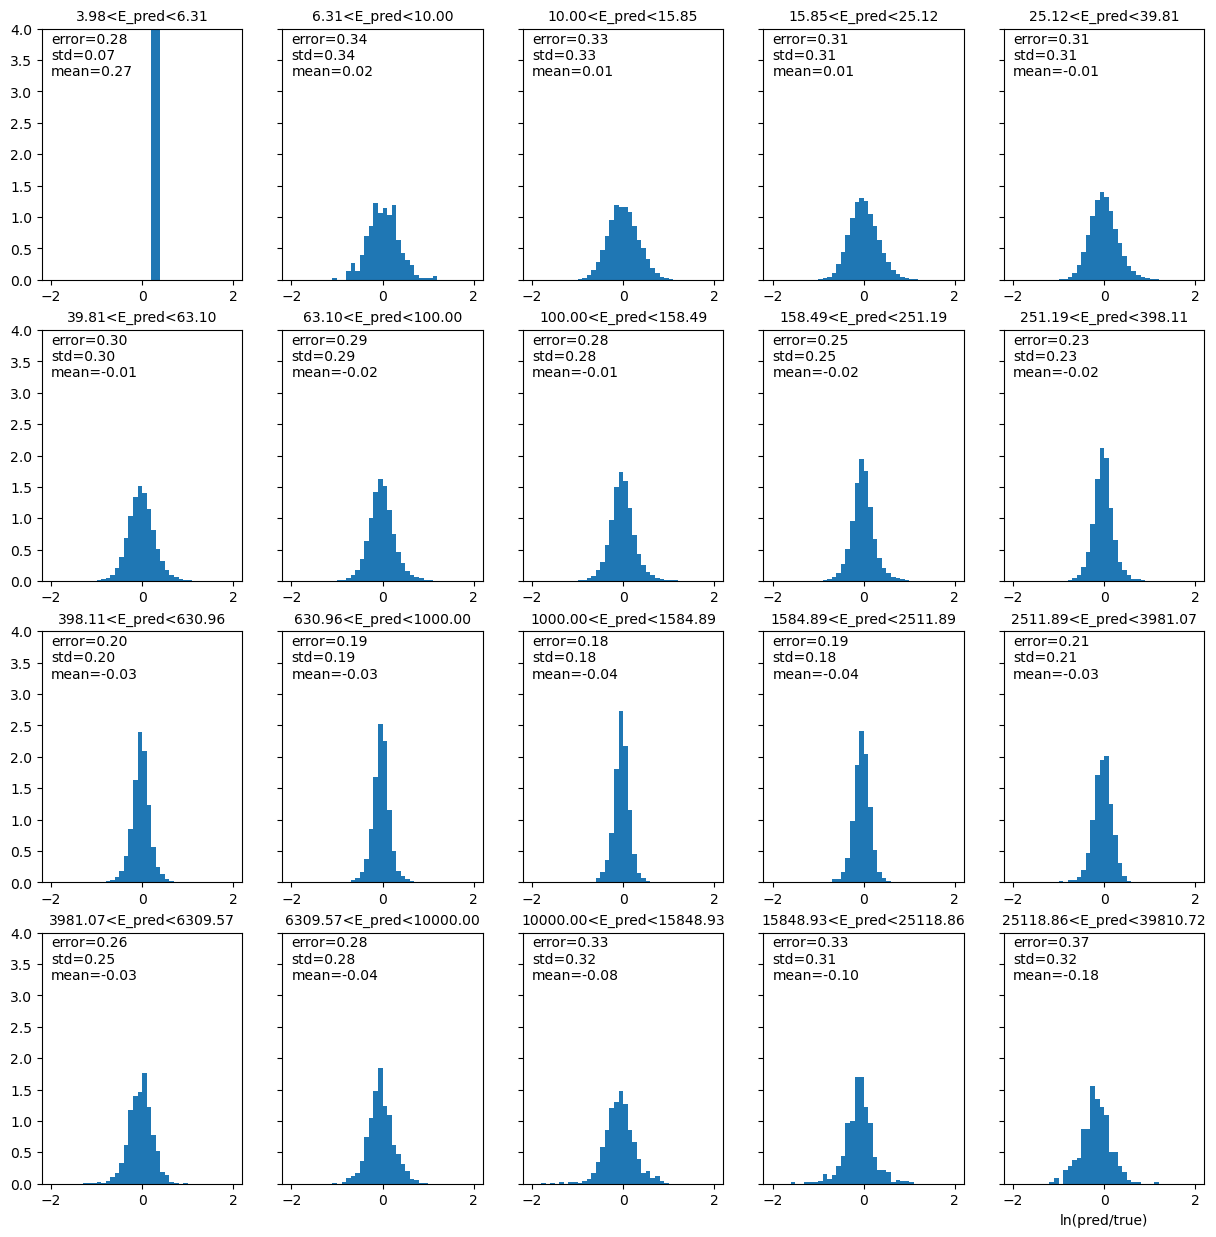

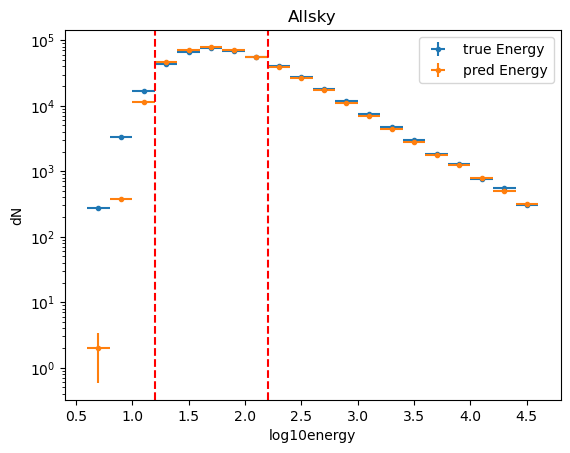

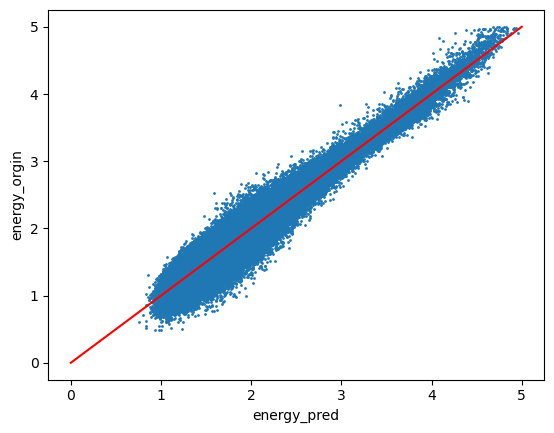

3.9810717055349722 6.309573444801932 -0.9927536231884058
6.309573444801932 10.0 -0.8853308935651113
10.0 15.848931924611133 -0.31425113464447807
15.848931924611133 25.118864315095795 0.0996446240680092
25.118864315095795 39.81071705534971 0.07934297176595262
39.81071705534971 63.0957344480193 0.052364684530799614
63.0957344480193 100.0 0.01076849889720192
100.0 158.48931924611125 -0.005338749977530513
158.48931924611125 251.18864315095797 -0.038028791824301085
251.18864315095797 398.1071705534969 -0.05468186408887606
398.1071705534969 630.957344480193 -0.04475493941709421
630.957344480193 1000.0 -0.05515953835709436
1000.0 1584.8931924611124 -0.04384781435509984
1584.8931924611124 2511.88643150958 -0.0642570281124498
2511.88643150958 3981.071705534969 -0.04659014179608373
3981.071705534969 6309.57344480193 -0.022270505160239002
6309.57344480193 10000.0 -0.03168469860896445
10000.0 15848.931924611108 0.05665349143610013
15848.931924611108 25118.86431509577 -0.10251798561151079
25118.864

In [28]:
energy_orgin = test_data_autogluon["prie"].to_numpy()/1000
energy_pred= 10**model_dict["log10Energy"].predict(test_data_autogluon.drop(columns=columns_drop)).to_numpy()
check_fit(energy_pred, energy_orgin, f"Allsky", f"/home2/hky/github/Gamma_Energy/AllSky/forJ1857/medium_quality_withoutcut")

In [29]:
file_J1857 = uproot.open("/home2/hky/github/Gamma_Energy/AllSky/forJ1857/RESULT_J1857.root")
data_J1857 = file_J1857["asresult"].arrays(["nch", "theta", "phi", "sigma", "cx", "cy", "sumpf",
                               "summd", "mr1", "ne", "age", "pritheta", "priphi", "prie", "inout"], library="np")
data_J1857["cr"] = np.sqrt(data_J1857["cx"]**2+data_J1857["cy"]**2)
data_J1857["log10Energy"] = np.log10(data_J1857["prie"]/1000)
data_J1857["pritheta"] = np.rad2deg(data_J1857["pritheta"])
data_J1857["priphi"] = 180-np.rad2deg(data_J1857["priphi"])
data_J1857["priphi"][data_J1857["priphi"] > 180] = data_J1857["priphi"][data_J1857["priphi"] > 180]-360
data_J1857["S50"] = getS50(data_J1857["ne"], data_J1857["age"])
data_J1857["deltatheta"] = data_J1857["theta"]-data_J1857["pritheta"]
data_J1857["deltaphi"] = data_J1857["phi"]-data_J1857["priphi"]
data_J1857["deltaphi"][data_J1857["deltaphi"] <-180]+=360
data_J1857["deltaphi"][data_J1857["deltaphi"] >180]-=360

In [30]:
cuted_J1857 = np.where((data_J1857["theta"] < 50) & (data_J1857["nch"] >= 16)
                 & (data_J1857["inout"] == 1) & (data_J1857['sigma'] < 1.)
                 & (data_J1857["age"] > 0.31) & (data_J1857['age'] < 1.3)
                 & (data_J1857["S50"] > 10**-1.2)
                 & (data_J1857['sumpf'] > 200)
                 & ((data_J1857["summd"] < 1.8e-5*data_J1857["sumpf"]**1.8) | (data_J1857["summd"] < 0.4)))


In [31]:
data_test_J1857 = {key:data_J1857[key][cuted_J1857] for key in data_J1857.keys()}

In [32]:
pd_data_J1857 = pd.DataFrame(data_test_J1857)
pd_data_J1857[["ne","sumpf"]]=np.log10(pd_data_J1857[["ne","sumpf"]])


In [33]:
J1857_autogluon = TabularDataset(pd_data_J1857)

/home2/hky/miniconda3/envs/ag/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home2/hky/miniconda3/envs/ag/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


<Figure size 640x480 with 0 Axes>

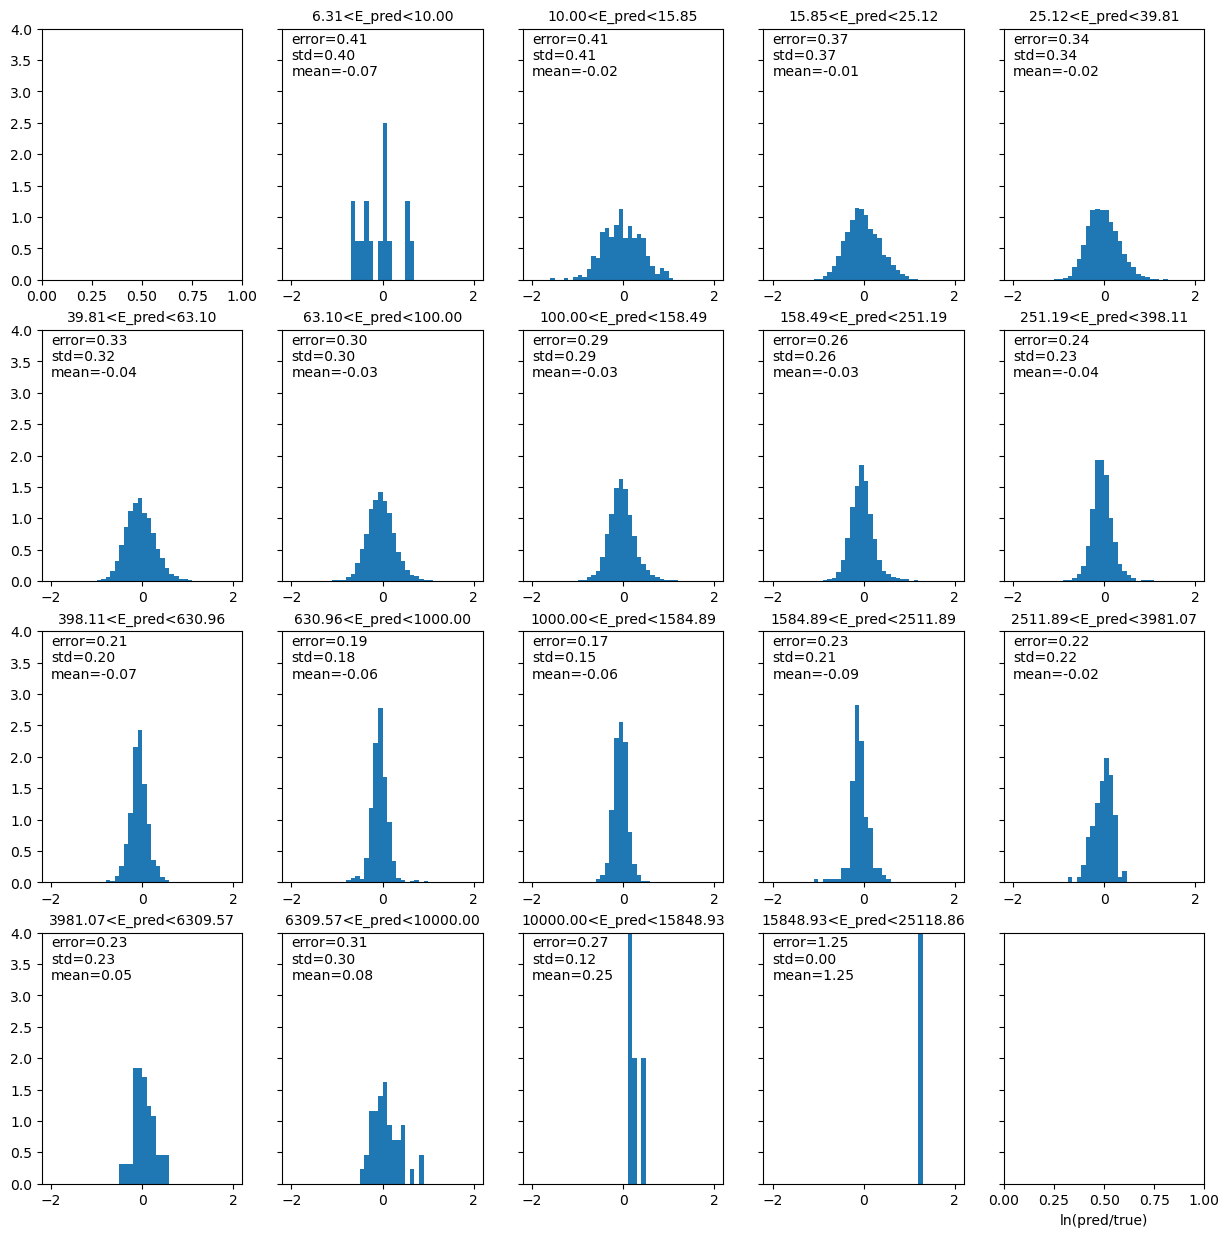

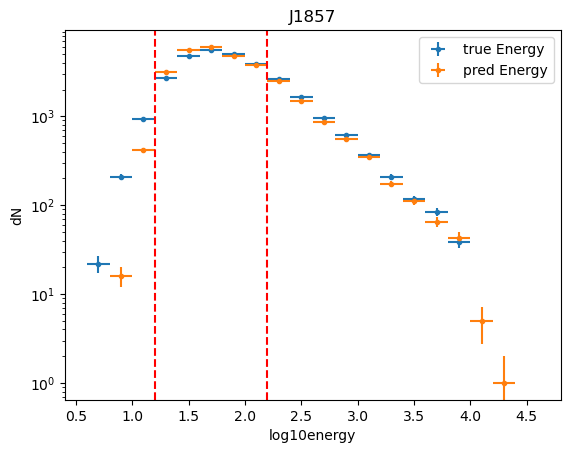

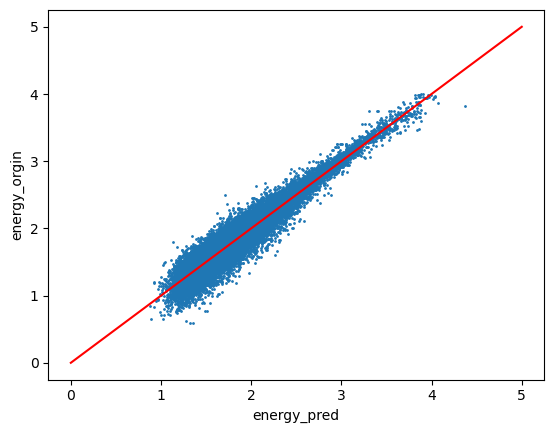

3.9810717055349722 6.309573444801932 -1.0
6.309573444801932 10.0 -0.9230769230769231
10.0 15.848931924611133 -0.55
15.848931924611133 25.118864315095795 0.1546353975815317
25.118864315095795 39.81071705534971 0.15287546545304095
39.81071705534971 63.0957344480193 0.07861919392734502
63.0957344480193 100.0 -0.04501288915328178
100.0 158.48931924611125 -0.035623409669211195
158.48931924611125 251.18864315095797 -0.04911220249338874
251.18864315095797 398.1071705534969 -0.08751529987760098
398.1071705534969 630.957344480193 -0.09329140461215933
630.957344480193 1000.0 -0.10483870967741936
1000.0 1584.8931924611124 -0.051771117166212535
1584.8931924611124 2511.88643150958 -0.16826923076923078
2511.88643150958 3981.071705534969 -0.05128205128205128
3981.071705534969 6309.57344480193 -0.2261904761904762
6309.57344480193 10000.0 0.10256410256410256
10000.0 15848.931924611108 inf
15848.931924611108 25118.86431509577 inf
25118.86431509577 39810.71705534969 nan


/tmp/ipykernel_23082/797037394.py:89: RuntimeWarning: divide by zero encountered in long_scalars
  print(Energy_bin[i],Energy_bin[i+1],(hist_recon[i]-hist_orgin[i])/hist_orgin[i])
/tmp/ipykernel_23082/797037394.py:89: RuntimeWarning: invalid value encountered in long_scalars
  print(Energy_bin[i],Energy_bin[i+1],(hist_recon[i]-hist_orgin[i])/hist_orgin[i])


In [34]:
energy_orgin = J1857_autogluon["prie"].to_numpy()/1000
energy_pred= 10**model_dict["log10Energy"].predict(J1857_autogluon).to_numpy()
check_fit(energy_pred, energy_orgin, f"J1857", f"/home2/hky/github/Gamma_Energy/AllSky/forJ1857/medium_quality_J1857test_withoutcut")

/home2/hky/miniconda3/envs/ag/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home2/hky/miniconda3/envs/ag/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


<Figure size 640x480 with 0 Axes>

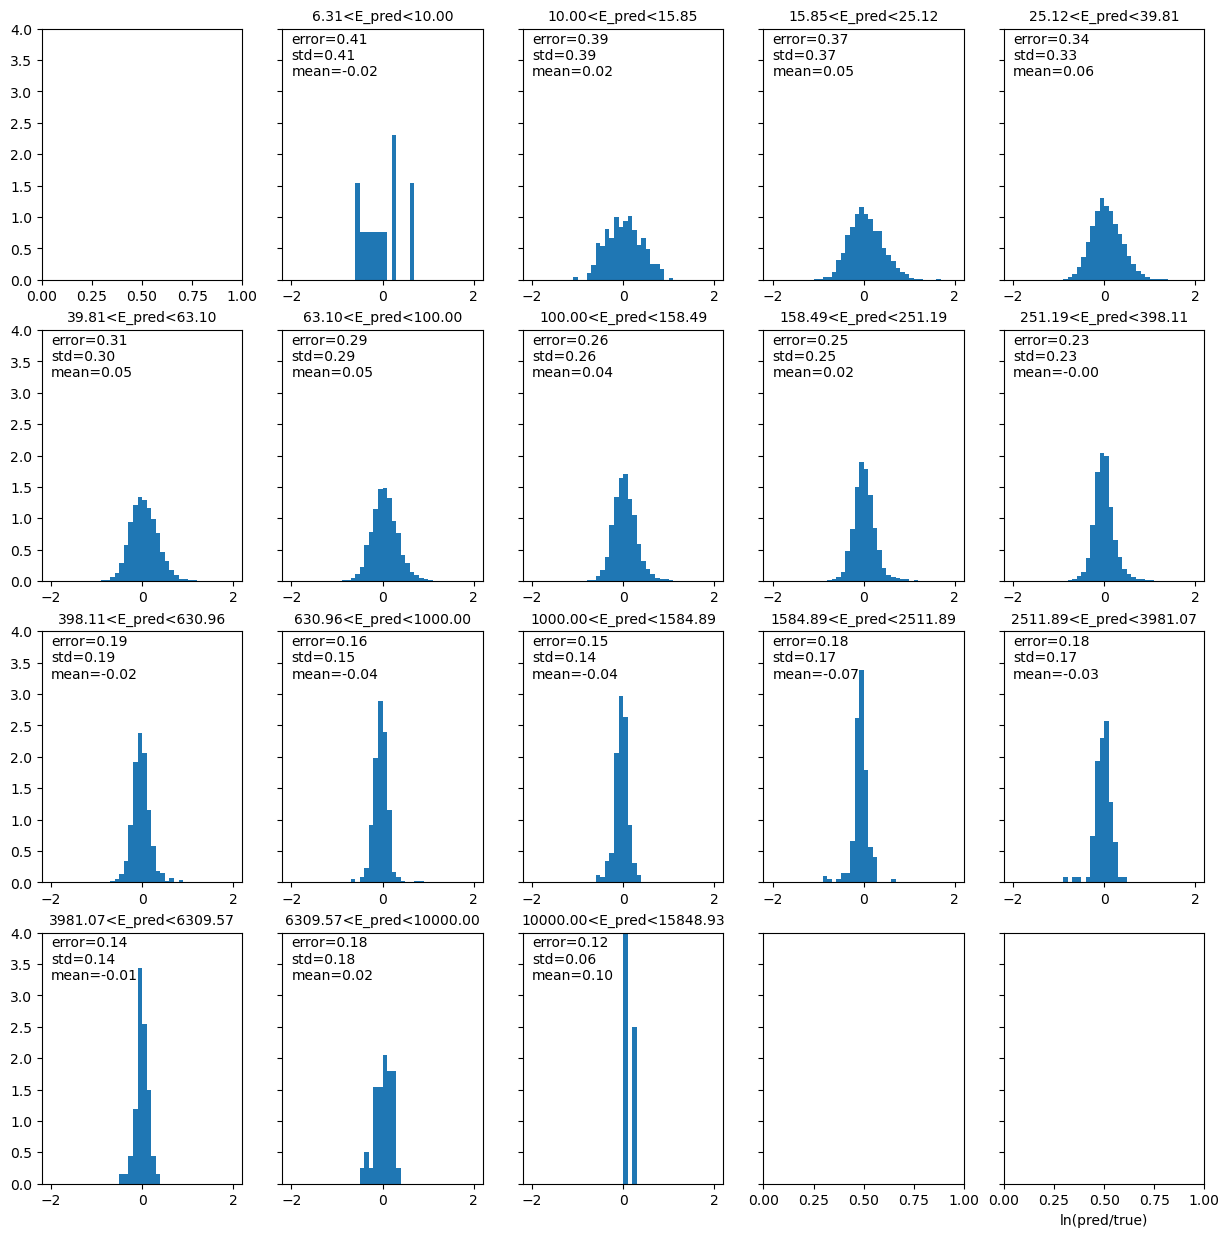

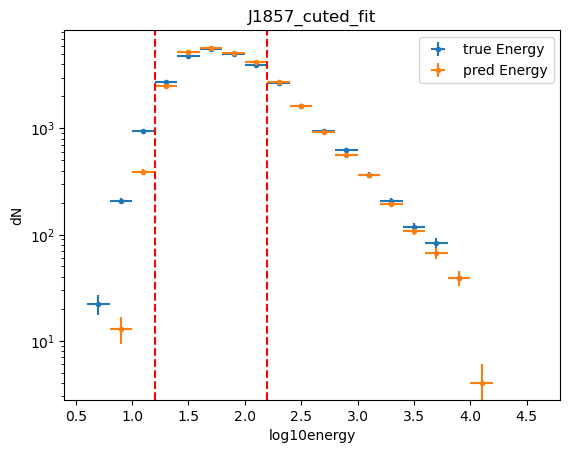

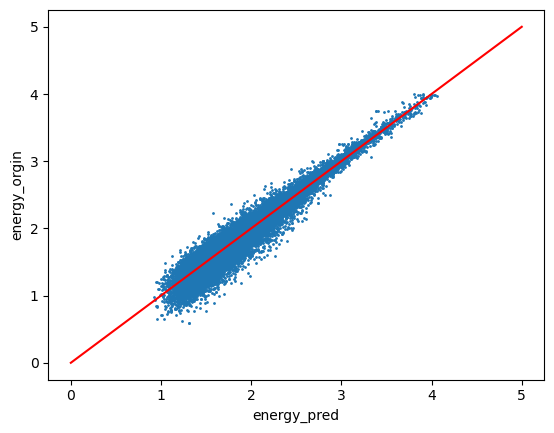

3.9810717055349722 6.309573444801932 -1.0
6.309573444801932 10.0 -0.9375
10.0 15.848931924611133 -0.5829787234042553
15.848931924611133 25.118864315095795 -0.0743862220593624
25.118864315095795 39.81071705534971 0.08336781133636739
39.81071705534971 63.0957344480193 0.0437375745526839
63.0957344480193 100.0 0.025381717231806464
100.0 158.48931924611125 0.06310432569974554
158.48931924611125 251.18864315095797 0.0404231205137892
251.18864315095797 398.1071705534969 -0.014075887392900856
398.1071705534969 630.957344480193 -0.040880503144654086
630.957344480193 1000.0 -0.08870967741935484
1000.0 1584.8931924611124 -0.01907356948228883
1584.8931924611124 2511.88643150958 -0.0625
2511.88643150958 3981.071705534969 -0.06837606837606838
3981.071705534969 6309.57344480193 -0.20238095238095238
6309.57344480193 10000.0 0.0
10000.0 15848.931924611108 inf
15848.931924611108 25118.86431509577 nan
25118.86431509577 39810.71705534969 nan


/tmp/ipykernel_23082/797037394.py:89: RuntimeWarning: divide by zero encountered in long_scalars
  print(Energy_bin[i],Energy_bin[i+1],(hist_recon[i]-hist_orgin[i])/hist_orgin[i])
/tmp/ipykernel_23082/797037394.py:89: RuntimeWarning: invalid value encountered in long_scalars
  print(Energy_bin[i],Energy_bin[i+1],(hist_recon[i]-hist_orgin[i])/hist_orgin[i])


In [40]:
energy_orgin = J1857_autogluon["prie"].to_numpy()/1000
predictor=TabularPredictor.load("/home2/hky/github/Gamma_Energy/AllSky/agModels_angle/log10Energy")
energy_pred= 10**predictor.predict(J1857_autogluon).to_numpy()
check_fit(energy_pred, energy_orgin, f"J1857_cuted_fit", f"/home2/hky/github/Gamma_Energy/AllSky/forJ1857/medium_quality_J1857test2")

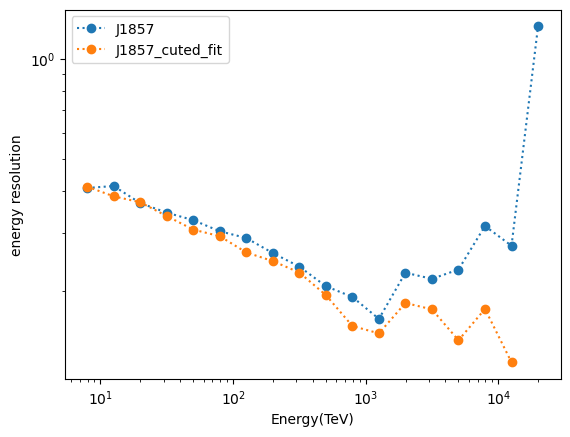

In [43]:
draw_precision()

In [44]:
newtheta = data_test["theta"]-model_dict["deltatheta"].predict(test_data_autogluon).to_numpy()
newphi = data_test["phi"]-model_dict["deltaphi"].predict(test_data_autogluon).to_numpy()
newtheta_J1857 = data_test_J1857["theta"]-model_dict["deltatheta"].predict(J1857_autogluon).to_numpy()
newphi_J1857 = data_test_J1857["phi"]-model_dict["deltaphi"].predict(J1857_autogluon).to_numpy()

In [45]:
deltaangle = twoPointAngle(
    data_test["theta"], data_test["pritheta"], data_test["phi"], data_test["priphi"])
newdeltaangle = twoPointAngle(
    newtheta, data_test["pritheta"], newphi, data_test["priphi"])
deltaangle_J1857 = twoPointAngle(
    data_test_J1857["theta"], data_test_J1857["pritheta"], data_test_J1857["phi"], data_test_J1857["priphi"])
newdeltaangle_J1857 = twoPointAngle(
    newtheta_J1857, data_test_J1857["pritheta"], newphi_J1857, data_test_J1857["priphi"])


In [46]:
anglesigma = list()
anglesigma_new = list()
anglesigma_J1857 = list()
anglesigma_new_J1857 = list()
energy_orgin = data_test["prie"]/1000
energy_orgin_J1857 = data_test_J1857["prie"]/1000
for i in range(len(Energy_bin)-1):
    tmp_cuted = np.where((energy_orgin > Energy_bin[i]) & (
        energy_orgin < Energy_bin[i+1]))
    anglesigma.append(np.sqrt(np.mean(deltaangle[tmp_cuted]**2)))
    anglesigma_new.append(np.sqrt(np.mean(newdeltaangle[tmp_cuted]**2)))

    tmp_cuted = np.where((energy_orgin_J1857 > Energy_bin[i]) & (
        energy_orgin_J1857 < Energy_bin[i+1]))
    anglesigma_J1857.append(np.sqrt(np.mean(deltaangle_J1857[tmp_cuted]**2)))
    anglesigma_new_J1857.append(np.sqrt(np.mean(newdeltaangle_J1857[tmp_cuted]**2)))


/home2/hky/miniconda3/envs/ag/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home2/hky/miniconda3/envs/ag/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


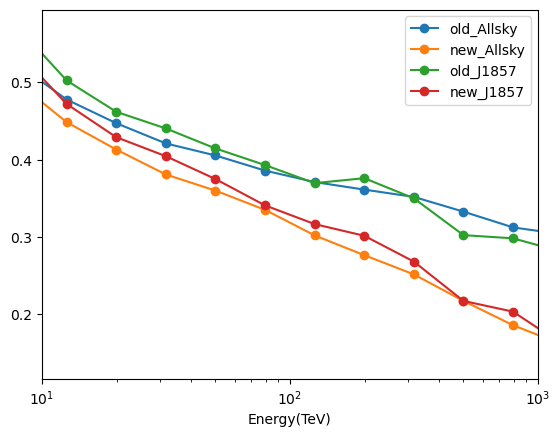

In [47]:
plt.plot(Energy_bin_center,anglesigma,"o-",label="old_Allsky")
plt.plot(Energy_bin_center,anglesigma_new,"o-",label="new_Allsky")
plt.plot(Energy_bin_center,anglesigma_J1857,"o-",label="old_J1857")
plt.plot(Energy_bin_center,anglesigma_new_J1857,"o-",label="new_J1857")
plt.xscale("log")
plt.xlabel("Energy(TeV)")
plt.xlim(10,1000)
plt.legend()